In [283]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp 
import scipy.constants  as cts
import magpylib as magpy
from scipy.stats import rv_continuous
from scipy.interpolate import RegularGridInterpolator
import multiprocessing as mp

In [372]:
0.1*5

0.5

In [373]:
tfmot = magpy.Collection()
N = 2
angles = [45,135,225,315]
angles_d = [180,0,180,0]
l = 30
halbach = magpy.Collection()
mstyle = dict(
    mode="color+arrow",
    color=dict(north="magenta", middle="white", south="turquoise"),
    arrow=dict(width=2, color="k")
)
for a in range(len(angles)):
    cube= magpy.magnet.Cuboid(
    dimension=(8,6,80),
    polarization=(1.42,0,0),
    position=(30+l,0,0),
    style_magnetization=mstyle )
    
    cube.rotate_from_angax(angles[a], 'z',anchor = 0)
    cube.rotate_from_angax(angles_d[a], 'z')

    tfmot.add(cube)

magpy.show(tfmot, backend='plotly',)

In [376]:
10*5

50

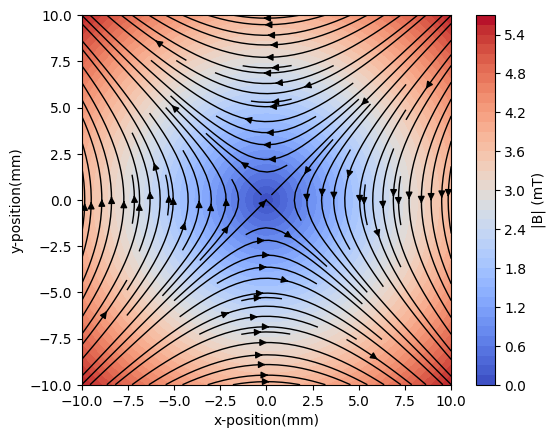

In [374]:
# Continuation from above - ensure previous code is executed

import matplotlib.pyplot as plt
fig, ax = plt.subplots()

# Compute and plot field on x-y grid
grid = np.mgrid[-10:10:100j, -10:10:100j, 0:0:1j].T[0]
X, Y, _ = np.moveaxis(grid, 2, 0)

B = tfmot.getB(grid)*1e3
Bx, By, _ = np.moveaxis(B, 2, 0)
Bamp = np.linalg.norm(B, axis=2)

pc = ax.contourf(X, Y, Bamp, levels=50, cmap="coolwarm")
ax.streamplot(X, Y, Bx, By, color="k", density=1.5, linewidth=1)

# Add colorbar
fig.colorbar(pc, ax=ax, label="|B| (mT)")

# Figure styling
ax.set(
    xlabel="x-position(mm)",
    ylabel="y-position(mm)",
    aspect=1,
)

plt.show()

In [340]:
def v_avg(m,T):
    return np.sqrt(8*cts.k*T/(np.pi*m))

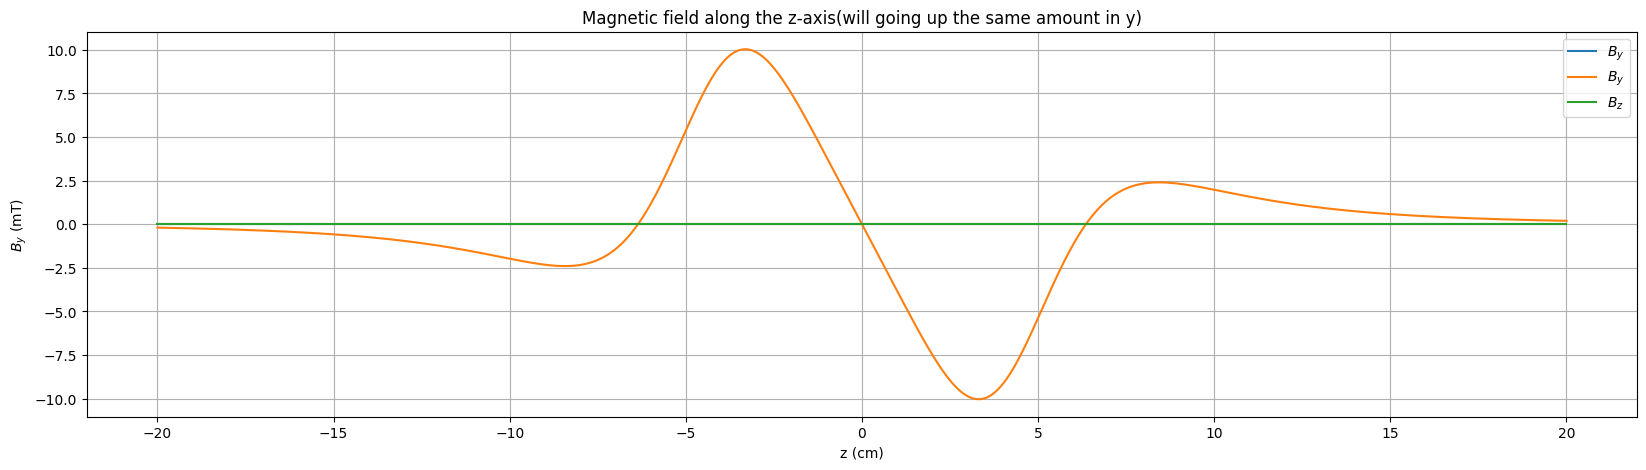

In [375]:
L = 16
z = np.linspace(-20,20,1000)
b_y = []
b_z = []
b_x = []
for i in z:
    b_x.append(tfmot.getB([i*10,0,0])[0])
    b_y.append(tfmot.getB([i*10,0,0])[1])
    b_z.append(tfmot.getB([i*10,0,0])[2])

fig,ax = plt.subplots(1,1,figsize=(20,5))    
plt.plot(z,np.array(b_x)*1e3)
plt.plot(z,np.array(b_y)*1e3)
plt.plot(z,np.array(b_z)*1e3)

plt.xlabel('z (cm)')

plt.ylabel('$B$ (mT)')
plt.legend(['$B_y$','$B_y$','$B_z$','Analytical'])  
plt.ylabel('$B_y$ (mT)')
plt.title('Magnetic field along the z-axis(will going up the same amount in y)')
plt.grid()

In [377]:
mass_lab = 173*cts.value('atomic mass constant') # YB-173 mass in kg
v_a = v_avg(mass_lab,216.85)
sd = np.sqrt(cts.k*216.85/mass_lab)
vel = np.random.normal(v_a,sd,1000000)
klab = 2*np.pi*25068.2222# Lab wavevector (without 2pi) in cm^{-1}   # Lifetime of 6P_{3/2} state (in seconds)
gammalab = (1.93*1e8)
v0 =max(vel)
Blab = -67*1e-3#(v0*cts.hbar*(klab*100))/cts.value('Bohr magneton')
b_0L =  48*1e-3
# (v0*cts.hbar*(klab*100))/cts.value('Bohr magneton')/2
# T # About 15 G/cm is a typical gradient for Rb
L = 16
x0 = 1/klab  # cm
t0 = 1/gammalab  # s
#100*(mass_lab*(v0**2))/(0.5*cts.hbar*(klab*100)*gammalab) +5
print(Blab, L,v0,b_0L)

-0.067 16 645.0329181748854 0.048


In [378]:
x0 = 1/klab  # cm
t0 = 1/gammalab  # s

mass = mass_lab*(x0*1e-2)**2/cts.hbar/t0

# And now our wavevector, decay rate, and magnetic field gradient in these units:
k = klab*x0
gamma = gammalab*t0
alpha = cts.value('Bohr magneton')*Blab*t0/cts.hbar
b_0 = cts.value('Bohr magneton')*b_0L*t0/cts.hbar 
l = L/x0 

print(x0, t0, mass, k, gamma, alpha,b_0)

6.348872362073421e-06 5.181347150259067e-09 2119.188266564296 1.0 1.0 -30.52874111941582 21.871336921372524


In [379]:
# Define the atomic Hamiltonian:
H_g_D2, mu_q_g_D2 = pylcp.hamiltonians.hyperfine_coupled(
0, 5/2, 0,  	-0.2592,
    Ahfs = 0, Bhfs=0, Chfs=0,
    muB=1)# ground state 1s0
H_e_D2, mu_q_e_D2 = pylcp.hamiltonians.hyperfine_coupled(
1, 5/2, 1.035,	-0.2592,
    Ahfs=59.52*1e6,Bhfs = 601.87*1e6 , Chfs= 0,
    muB=1) #excited state 1p1

dijq_D2 = pylcp.hamiltonians.dqij_two_hyperfine_manifolds(0, 1, 5/2)

E_e_D2 = np.unique(np.diagonal(H_e_D2))
E_g_D2 = np.unique(np.diagonal(H_g_D2))
hamiltonian_D2 = pylcp.hamiltonian(mass = mass)
hamiltonian_D2.add_H_0_block('g', H_g_D2)
hamiltonian_D2.add_H_0_block('e', H_e_D2)
hamiltonian_D2.add_d_q_block('g', 'e', dijq_D2, gamma = gamma, k = k)
hamiltonian_D2.add_mu_q_block('g', mu_q_g_D2)
hamiltonian_D2.add_mu_q_block('e', mu_q_e_D2)



#ham = pylcp.hamiltonian(Hg, He, mugq, mueq, dijq, mass=mass, gamma=gamma, k=k)
# Define the atomic Hamiltonian:
H_g_D2, mu_q_g_D2 = pylcp.hamiltonians.hyperfine_coupled(
0, 5/2, 0,  	-0.2592,
    Ahfs = 0, Bhfs=0, Chfs=0,
    muB=1)# ground state 1s0
H_e_D2, mu_q_e_D2 = pylcp.hamiltonians.hyperfine_coupled(
1, 5/2, 1.035,	-0.2592,
    Ahfs=59.52*1e6,Bhfs = 601.87*1e6 , Chfs= 0,
    muB=1) #excited state 1p1

dijq_D2 = pylcp.hamiltonians.dqij_two_hyperfine_manifolds(0, 1, 5/2)

E_e_D2 = np.unique(np.diagonal(H_e_D2))
E_g_D2 = np.unique(np.diagonal(H_g_D2))
hamiltonian_D2 = pylcp.hamiltonian(mass = mass)
hamiltonian_D2.add_H_0_block('g', H_g_D2)
hamiltonian_D2.add_H_0_block('e', H_e_D2)
hamiltonian_D2.add_d_q_block('g', 'e', dijq_D2, gamma = gamma, k = k)
hamiltonian_D2.add_mu_q_block('g', mu_q_g_D2)
hamiltonian_D2.add_mu_q_block('e', mu_q_e_D2)



#ham = pylcp.hamiltonian(Hg, He, mugq, mueq, dijq, mass=mass, gamma=gamma, k=k)


s = 10
det = -15
r = 0.4/x0 # this is for cylindrcal laser howver we want an eliptical one as this for somereason turns out to be better 
# Define the laser beams:
laserBeams = pylcp.laserBeams([
    {'kvec':np.array([0, 1, 0]), 's': s,'pol_coord':'spherical',   'pol':1, 'delta': (E_e_D2[2]-E_g_D2[0]) + det*gamma,'wb':r},
     {'kvec':np.array([0, -1, 0]), 's': s,'pol_coord':'spherical', 'pol':1, 'delta': (E_e_D2[2]-E_g_D2[0]) + det*gamma,'wb':r},
      {'kvec':np.array([1, 0, 0]), 's': s,'pol_coord':'spherical', 'pol':1, 'delta': (E_e_D2[2]-E_g_D2[0]) + det*gamma,'wb':r},
     {'kvec':np.array([-1, 0, 0]), 's': s,'pol_coord':'spherical', 'pol':1, 'delta': (E_e_D2[2]-E_g_D2[0]) + det*gamma ,'wb':r}],
    beam_type=pylcp.gaussianBeam) 

#linGrad =  pylcp.magField(lambda R: mag(R,b_0,alpha,l))
bf_mot = lambda R:tfmot.getB(R*10*x0)*cts.value('Bohr magneton')*t0/cts.hbar 
linGrad = pylcp.magField(lambda R: bf_mot(R))

In [380]:
rateeq = pylcp.rateeq(laserBeams, linGrad, hamiltonian_D2, include_mag_forces=False)

In [381]:
position = np.linspace(-0.4,0.4,20)
max_force = []
#for i in position:    
vc = x0/t0*1/(100)
Fc = cts.hbar*klab*gammalab
x = np.arange(-5, 5, 0.05)/x0
y = np.arange(-5, 5, 0.05)/x0
Z = np.arange(-5, 5, 0.5)/x0
v = np.arange(-150, 150, 30)/vc

V, X,Y,Z = np.meshgrid(v,x,y,z)

Rvec = np.array([1, 1,1])
Vvec = np.array([1,10, 1])
rateeq.generate_force_profile(Rvec, Vvec, name='Fz', progress_bar=True)
print(rateeq.profile['Fz'].F[2])

Completed in 0.33 s.
0.0


c:\Users\benfo\AppData\Local\Programs\Python\Python312\Lib\site-packages\pylcp\rateeq.py:264: ComplexWarning:

Casting complex values to real discards the imaginary part



In [382]:
# plt.plot(np.array(position)*10,max_force)
# plt.xlabel('z (mm)')
# plt.ylabel('Force (N)')
# plt.title('Force vs position(Z)')

In [383]:
# fig,ax = plt.subplots(1,1,figsize=(20,5))
Fc = gammalab*cts.hbar*klab*100
# im1 = ax.contourf(np.array(v)*x0,np.array(x)*vc, rateeq.profile['Fz'].F[1]*Fc)
# fig.subplots_adjust(left=0.08, wspace=0.2)
# cb1 = plt.colorbar(im1)
# cb1.set_label('$F(N)$')
# ax.set_ylabel('$z$ (cm)')
# ax.set_xlabel('$v (ms^{-1})$')
# plt.title('Contour plot of position vs velocity and force')

In [384]:
1/np.e**2*1.3

0.17593586820759652

In [385]:
# Constants
k_B = cts.k  # Boltzmann constant in J/K
 # Atomic mass of Yb-173
mass_kg = mass_lab  # Convert to kilograms
temperature = 405 + 273.15  # Convert Celsius to Kelvin

# Velocity Probability Function
def p(m, T, v):
    return (m / (k_B * T))**2 * np.exp(-m * v**2 / (2 * k_B * T)) * (v**3) / 2

In [386]:
class MaxwellBoltzmann(rv_continuous):
    def _pdf(self, v):
        return p(mass_kg, temperature, v)

# Define the custom distribution
maxwell_boltzmann = MaxwellBoltzmann(a=0, name="Maxwell-Boltzmann")

74


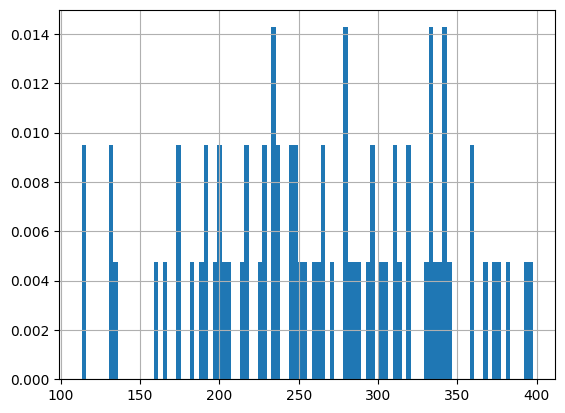

In [387]:
size = 100# Number of samples
velocities = maxwell_boltzmann.rvs(size=size)
velocities = velocities[velocities < 400]
velocities_t = [np.tan(35e-3)*i for i in velocities if i < 400]
v_0 = []
for i in range(len(velocities)):
    v_0.append([velocities_t[i],velocities_t[i],50])
# Display the sampled velocities
print(len(velocities))
plt.hist(velocities, bins=100, density=True)
plt.grid()


In [388]:
def simulate_trajectory_zeeman(v_0, t_span,a, mass_lab):
    x_t,y_t, v_tx, v_ty, t = [], [], [],[], []
    di = 0, 0  # Initial conditions
    s = [0,0,0]
    for q in range(len(t_span)):
        v_x = v_0[0]
        v_y = v_0[1]
        v_z = v_0[2]
    
        dt = t_span[q] - di
        
        f  = 0

        # Interpolate the force profile

        # Update position and velocity
   
        a_x   = 0
        a_y   = 0
        a_z   = 0

    

        s_x = (1/2)*a_x*(dt**2) + v_x*dt + s[0]
        
        s_y = (1/2)*a_y*(dt**2) + v_y*dt + s[0]

        s_z = (1/2)*a_z*(dt**2) + v_z*dt + s[0]
        
        v_x = v_x + a_x*dt

        v_y = v_y + a_y*dt

        v_z = v_z + a_z*dt

        # Append values
        x_t.append(s_x)
        y_t.append(s_y)
        v_tx.append(v_x)
        v_ty.append(v_y)
        t.append(t_span[q])
        di = t_span[q]
        v_0 = (v_x,v_y,v_z)
        s = (s_x,s_y,s_z)
       

    return x_t, y_t, v_tx, v_ty, t

In [300]:

x0_m = x0/100

def simulate_trajectory(v_0, t_span, mass_lab):
    x_t,y_t, v_tx, v_ty, t = [], [], [],[], []

    di = 0  # Initial conditions
    
    s = [0,0,0]
    
    for q in range(len(t_span)):
        v_x = v_0[0]
        v_y = v_0[1]
        v_z = v_0[2]
        
        dt = t_span[q] - di
        
        f  = rateeq.generate_force_profile(np.array(v_0)/vc,np.array(s)/x0_m,name='Fz', progress_bar=False)
        
        # Interpolate the force profile

        # Update position and velocity
    
        a_x = rateeq.profile['Fz'].F[0] * Fc / mass_lab

        a_y = rateeq.profile['Fz'].F[1] * Fc / mass_lab

        a_z = rateeq.profile['Fz'].F[2] * Fc / mass_lab        
        
        s_x = (1/2)*a_x*(dt**2) + v_x*dt + s[0]
        
        s_y = (1/2)*a_y*(dt**2) + v_y*dt + s[1]

        s_z = (1/2)*a_z*(dt**2) + v_z*dt + s[2]
        print(a_y)

        v_x = v_x + a_x*dt

        v_y = v_y + a_y*dt

        v_z = v_z + a_z*dt
        # Append values
        x_t.append(s_x)

        y_t.append(s_y)

        v_tx.append(v_x)

        v_ty.append(v_y)

        t.append(t_span[q])

        di = t_span[q]

        v_0 = [v_x,v_y,v_z]
        
        s = [s_x,s_y,s_z]



    return x_t, y_t, v_tx, v_ty, t

In [301]:
#the 2d mot is not working very well seems is is not slowing anythign down shown from the graph below. this could be do to mutliple reasons : detunning ,magfield,
x_n = []
y_n = []
v_tx_n = []
v_ty_n = []
t_n = []
t_max = 0.005
t_span =  np.linspace(0, t_max, 1000)
theta = 37e-3
#for key in force_profiles:
theta = 35e-3
tans_vel = np.array(velocities)*np.tan(theta)
b = 0
for  i in v_0:

    x_t, y_t, v_tx, v_ty, t = simulate_trajectory(i,t_span,mass_lab)

    x_n.append(x_t)

    y_n.append(y_t)

    v_tx_n.append(v_tx)

    v_ty_n.append(v_ty)

    t_n.append(t)

    b = b +1
    
    print(b)
    

-5.105400825896029
-5.105400825896029
-0.06227553335175829
-0.007522813419186942
-0.0024892477519203532
-0.0008694996785706216
-0.0005996990657250108
-0.0002223992433998429
-0.00017536167736065158
-0.00015736832008298704
-9.179870553084156e-05
-1.722194566160652e-05
-4.4470299644649045e-05
-4.859261159350553e-05
-4.0997556926897077e-05
-2.3117248983376264e-05
-1.686250958485211e-05
-2.3674332566902464e-05
-1.3212634083188062e-05
-2.2753444856111214e-05
-2.6793576776063225e-06
-2.023123327594294e-06
-1.2386268152950531e-05
-1.101968094918408e-05
-7.881228884245625e-07
-1.134850322251362e-05
-1.029740215832018e-05
-3.0992736131076956e-06
-2.75545035132952e-06
-2.4606481435211366e-06
-2.206497183836288e-06
2.1499271141428742e-07
-3.934390589197048e-06
-3.6334188095460467e-06
nan


ValueError: Unable to find solution at r=(nan,nan,nan) and v=(nan,nan,nan)

In [ ]:

# t_max = 0.005
# t_span =  np.linspace(0, t_max, 1000)
# theta = 37e-3
# # Define a list of initial velocities (v_0)
# initial_velocities = v_0

# # Create a pool of processes
# with mp.Pool(processes = mp.cpu_count()) as pool:
#     # Map only v_0 to simulate_trajectory; pass constant args using `starmap`
#     results = pool.starmap(
#         simulate_trajectory, [(v, t_span, mass_lab) for v in initial_velocities]
#     )

# # Save results into a new list
# all_trajectories = []
# for result in results:
#     all_trajectories.append(result)

# # Print the saved list
# for i, trajectory in enumerate(all_trajectories):
#     print(f"Trajectory {i + 1}:")
#     print("x_t:", trajectory[0])
#     print("y_t:", trajectory[1])
#     print()

In [ ]:
initial_y = []
final_y = []
for i in range(len(x_n)):

    final_y.append(v_ty_n[i][-1])
    initial_y.append(v_ty_n[i][0])

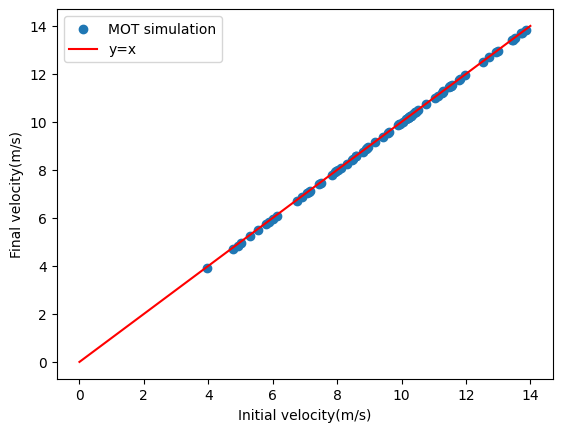

In [307]:
k  = np.linspace(0,14,100)

plt.scatter(initial_y,final_y)
plt.xlabel('Initial velocity(m/s)')
plt.ylabel('Final velocity(m/s)')
plt.plot(k,k,'r')
plt.legend(['MOT simulation','y=x'])